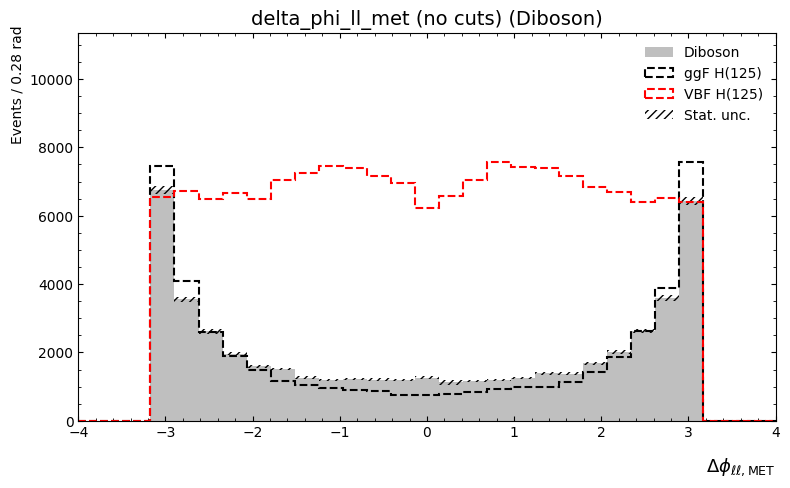

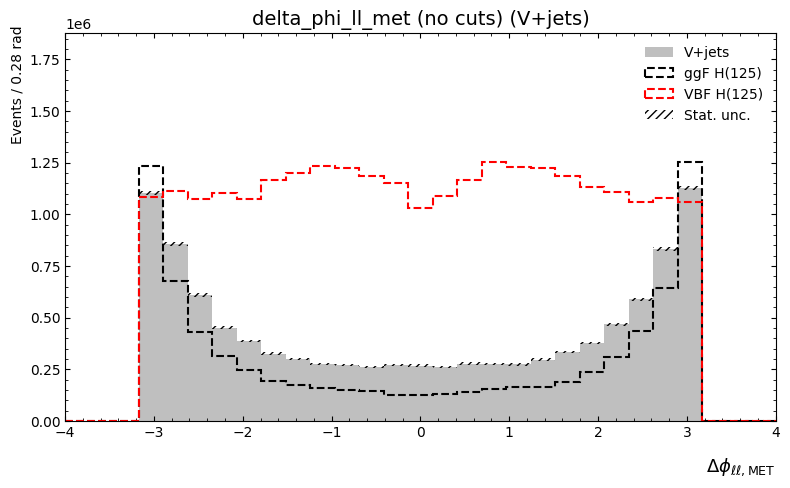

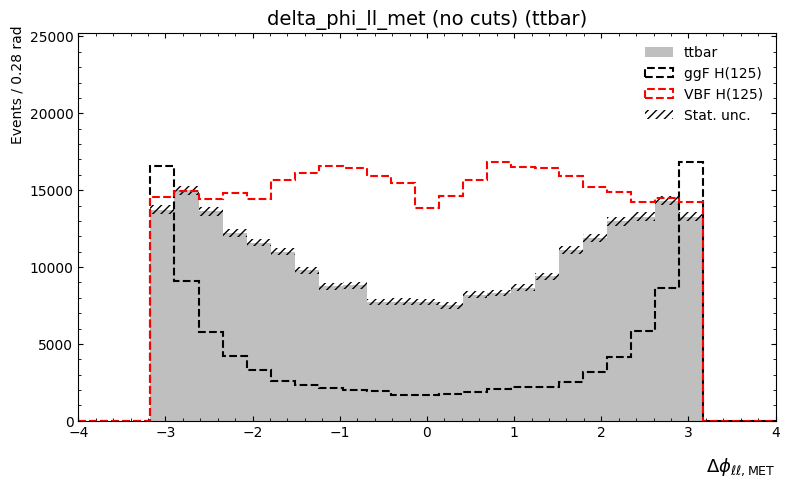

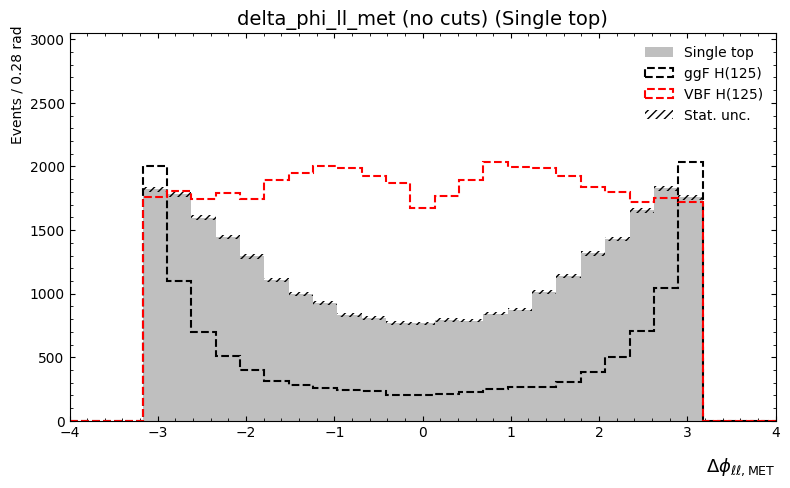

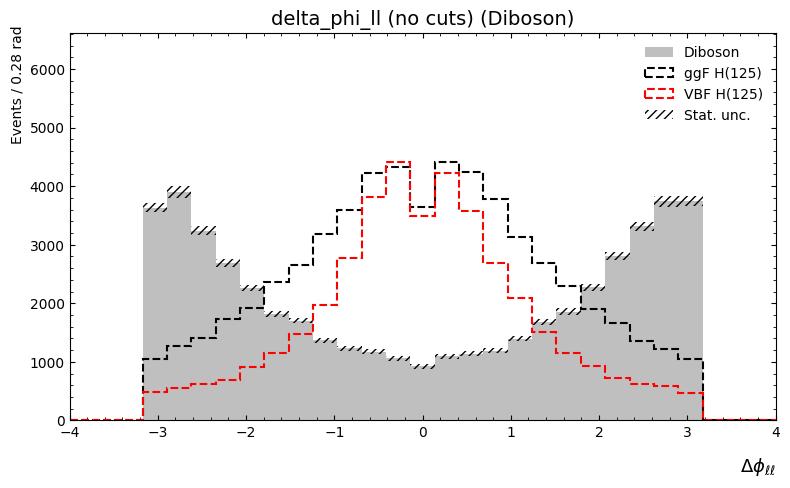

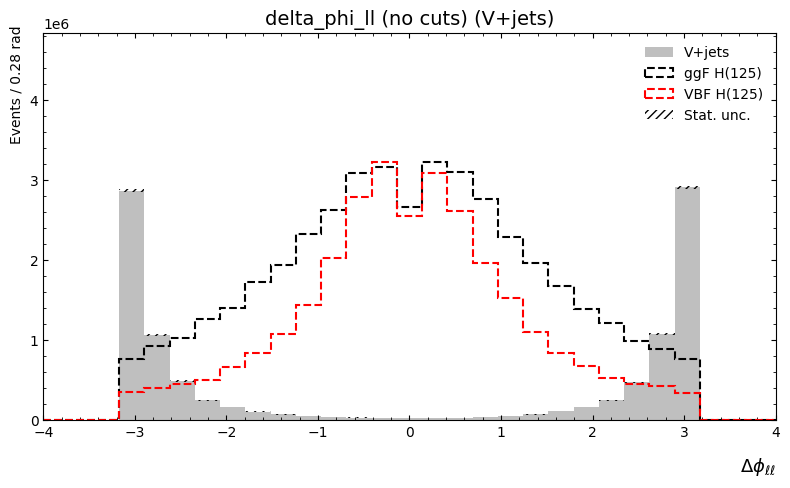

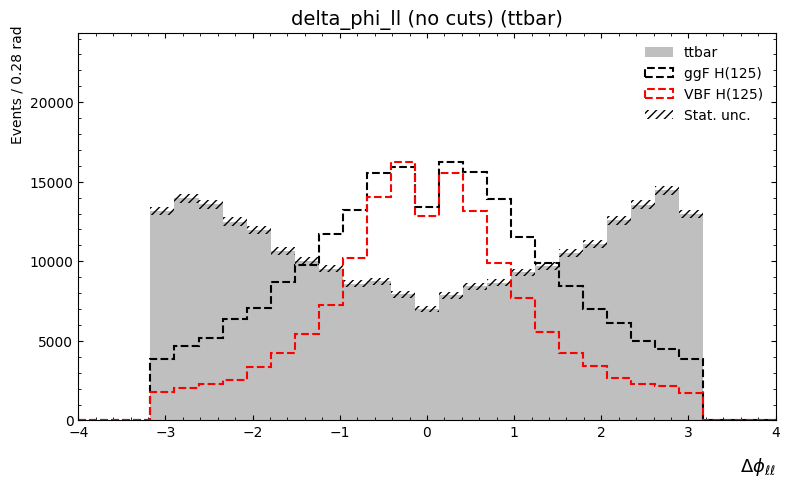

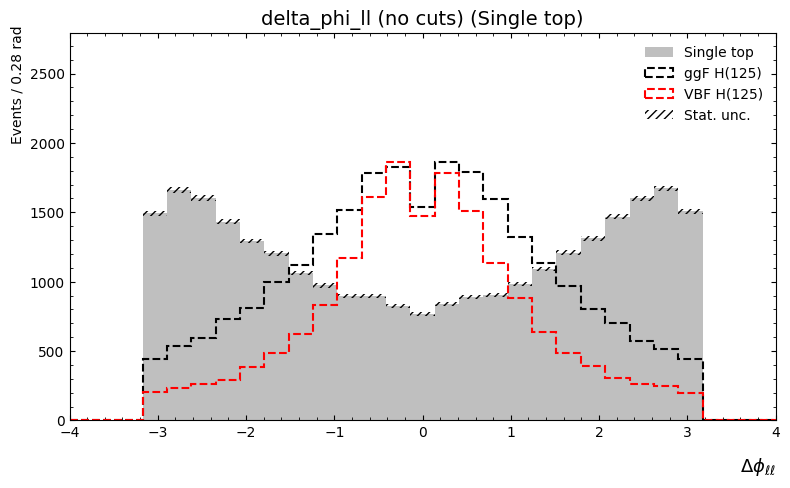

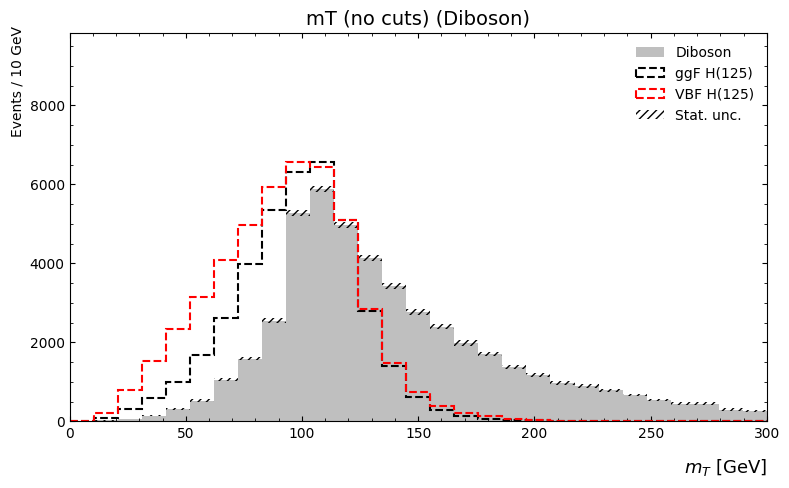

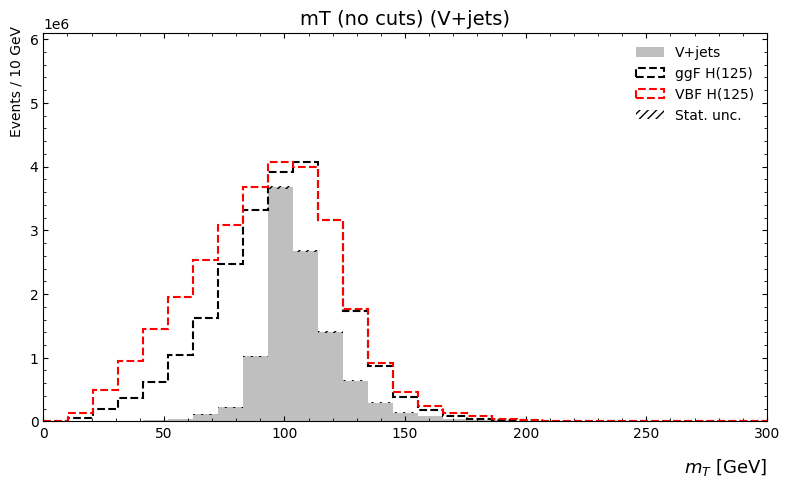

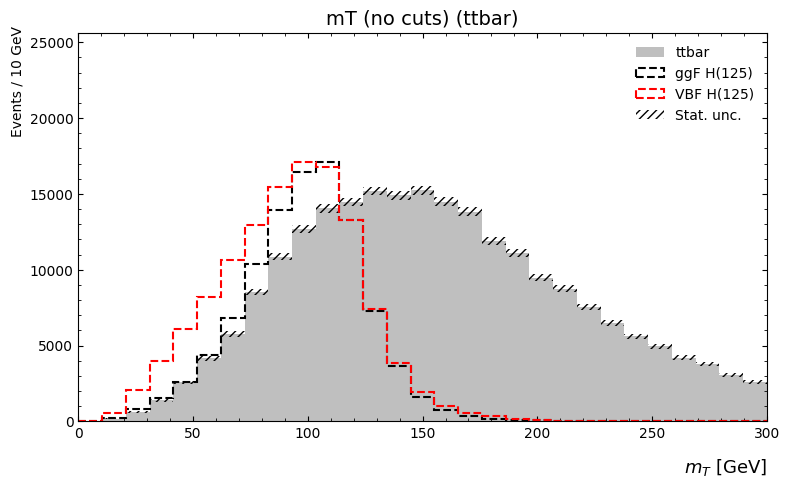

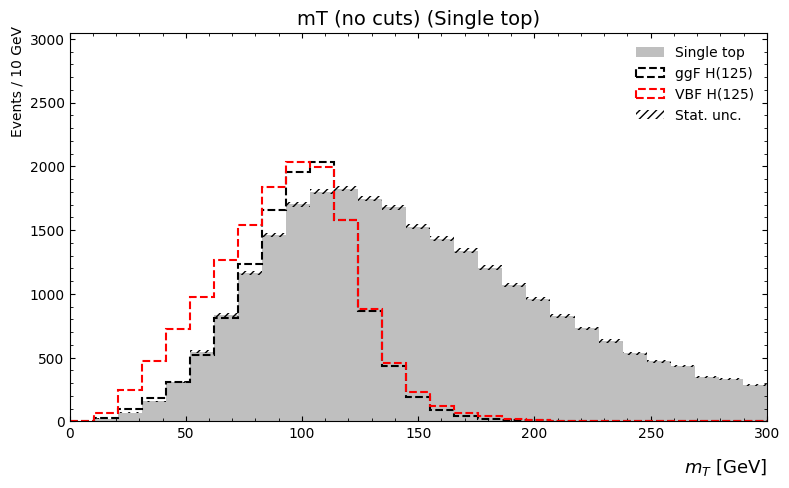

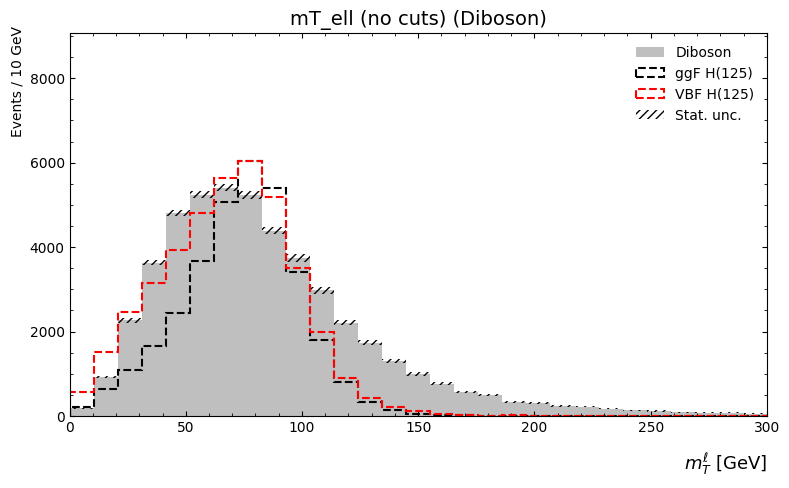

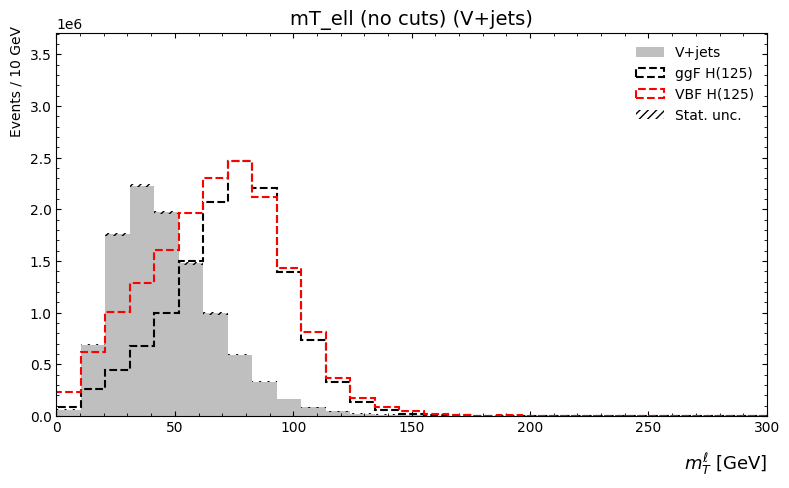

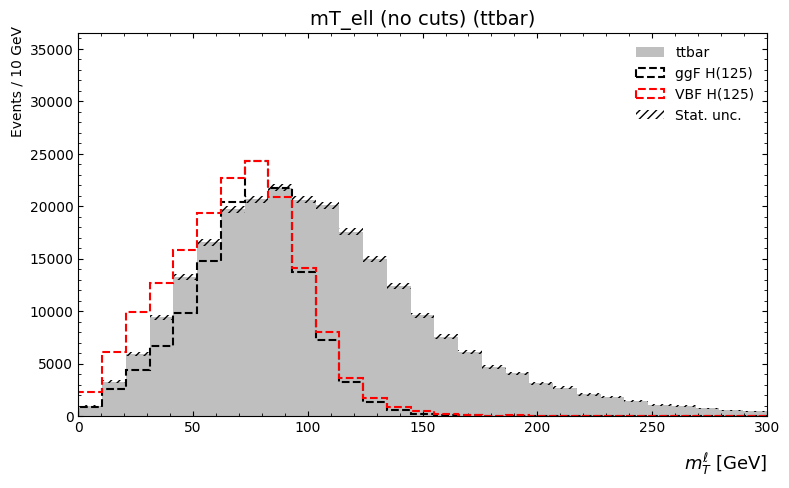

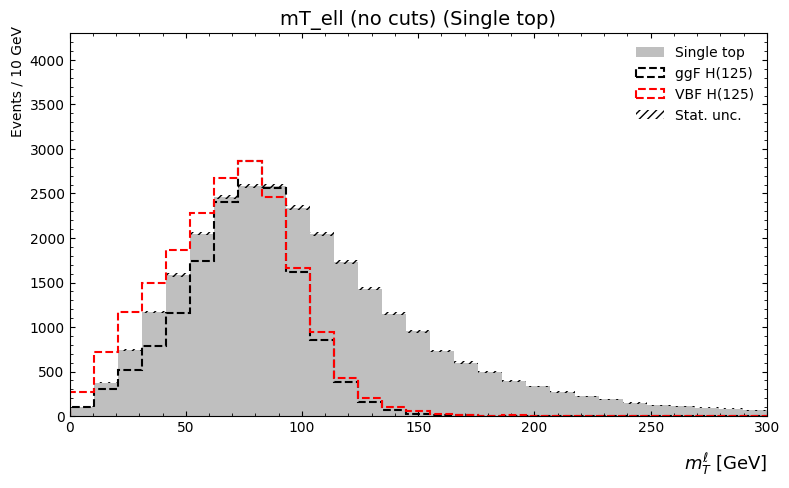

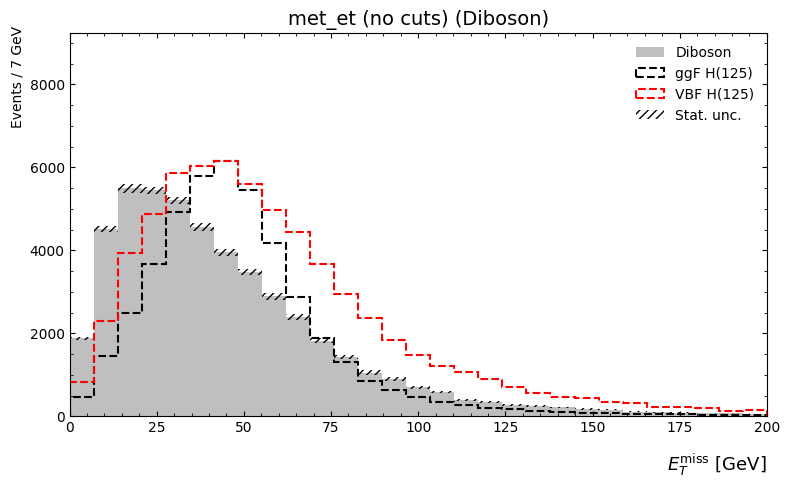

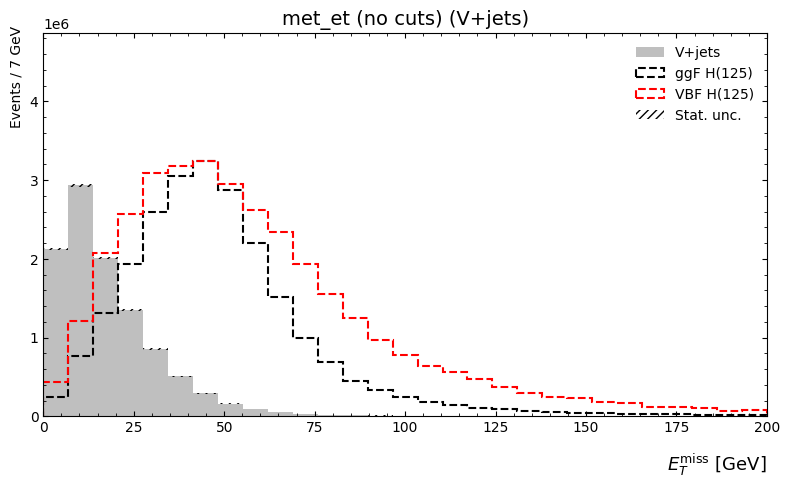

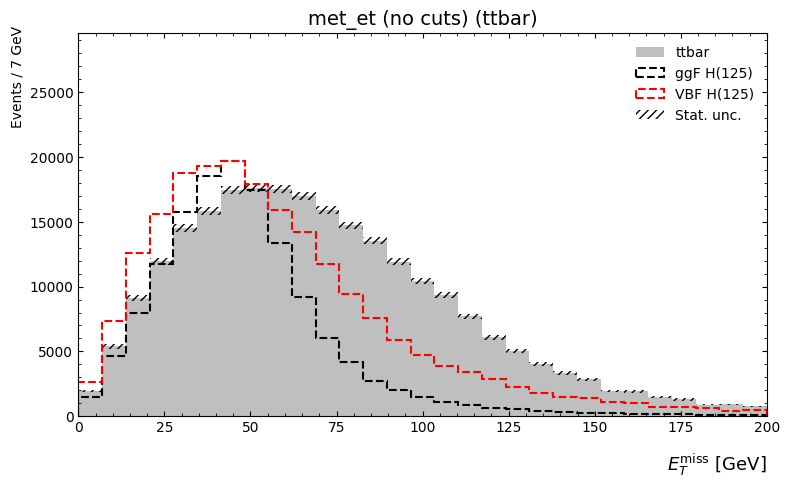

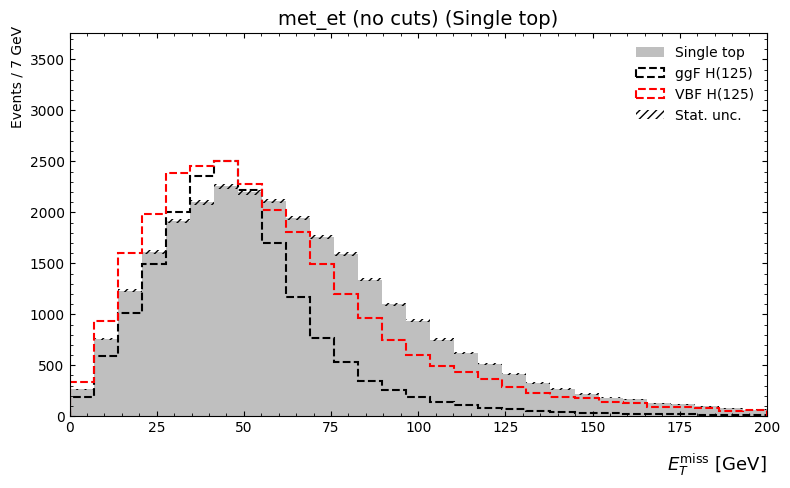

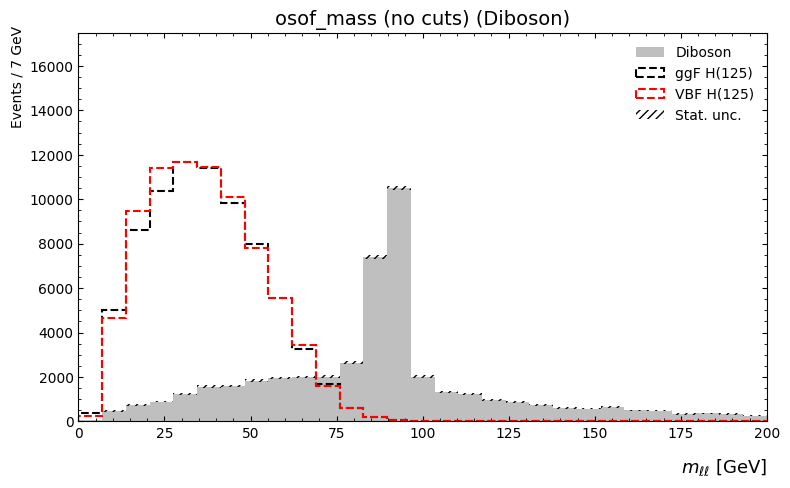

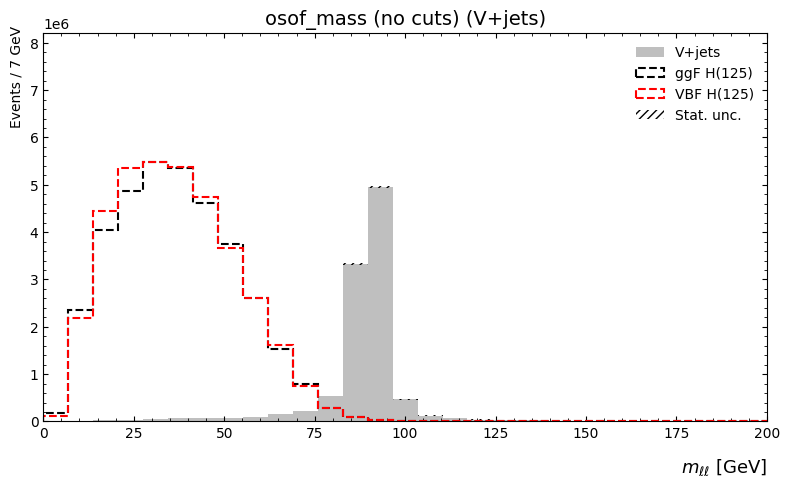

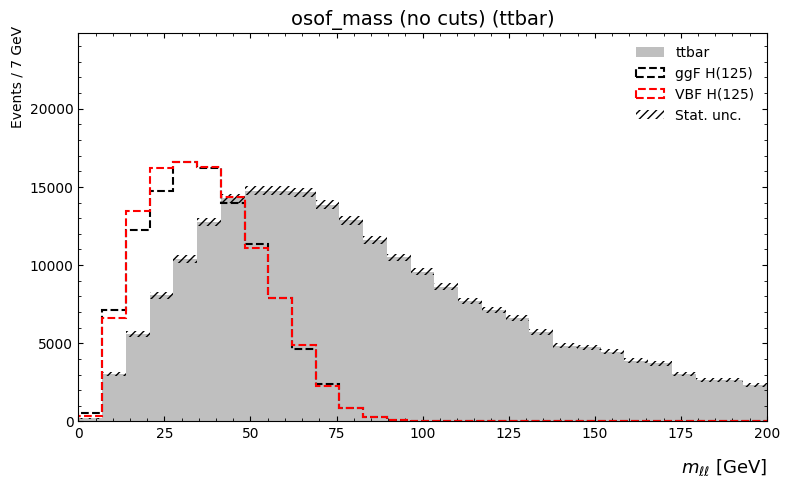

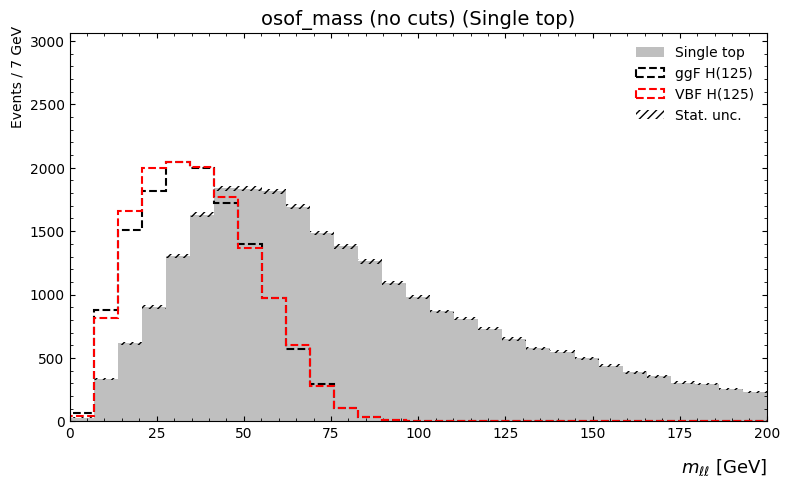

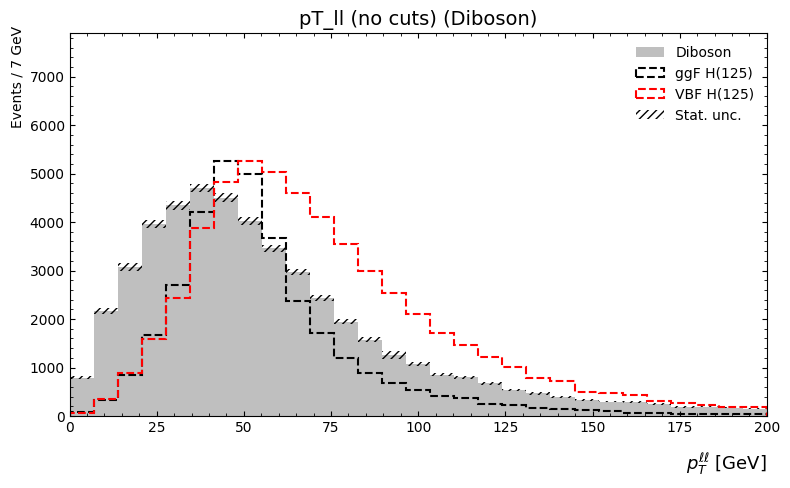

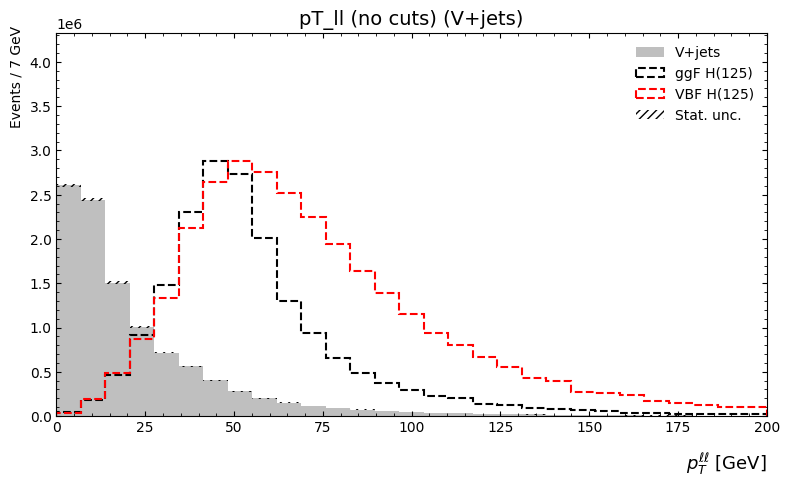

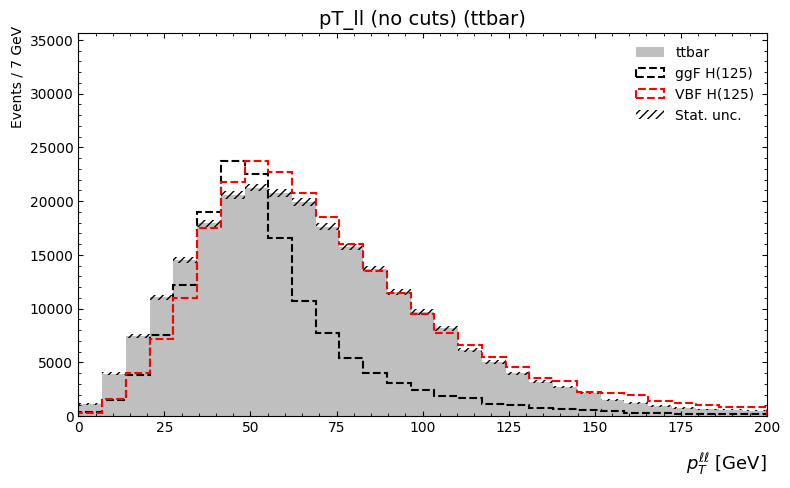

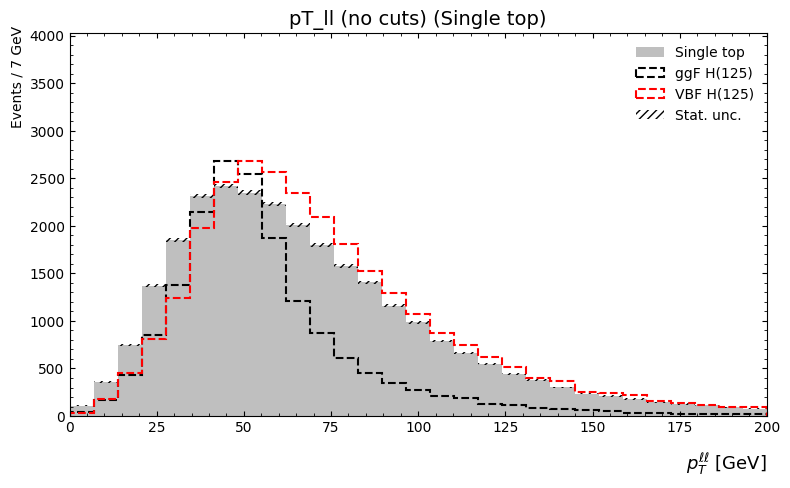

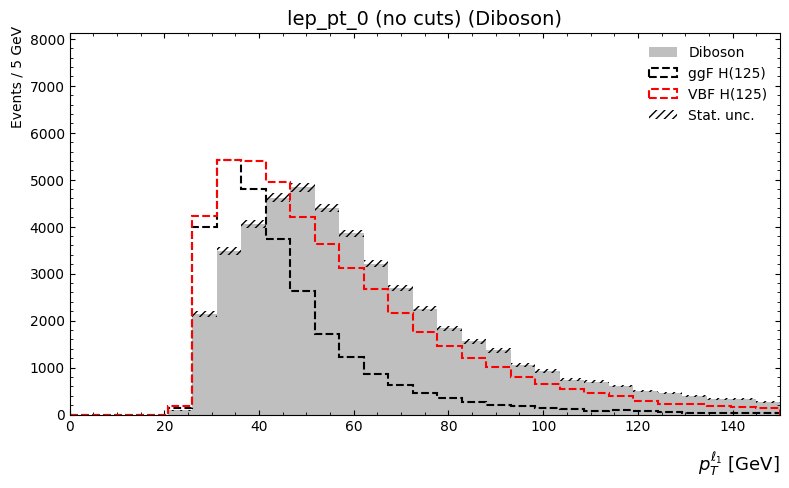

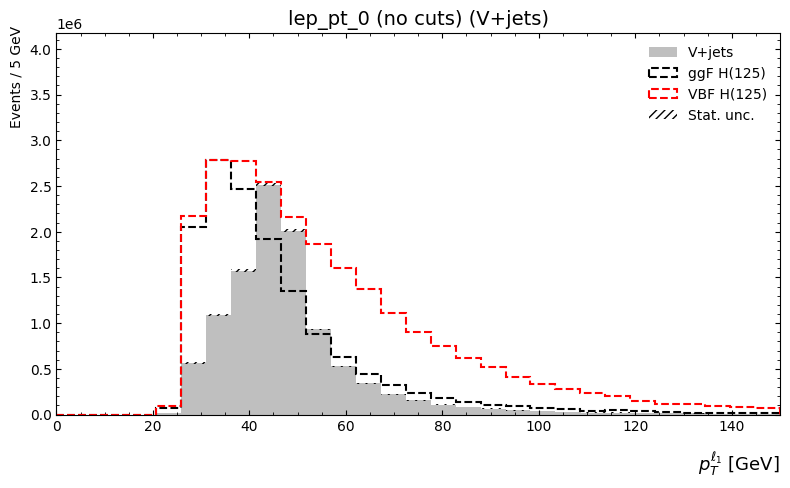

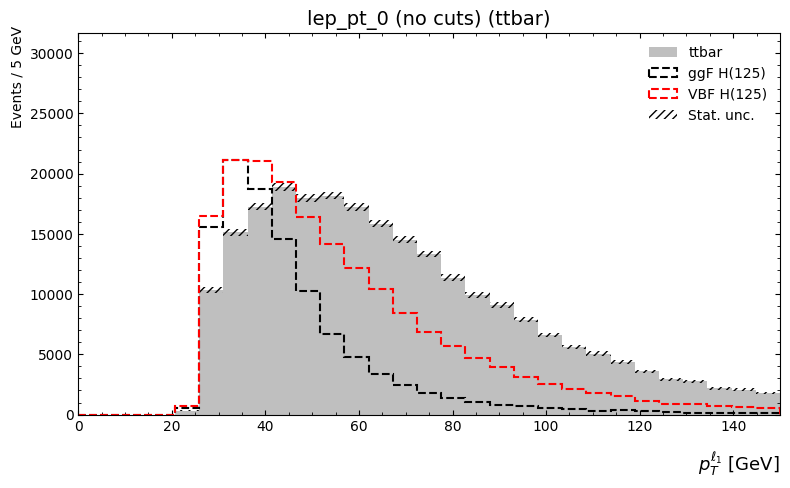

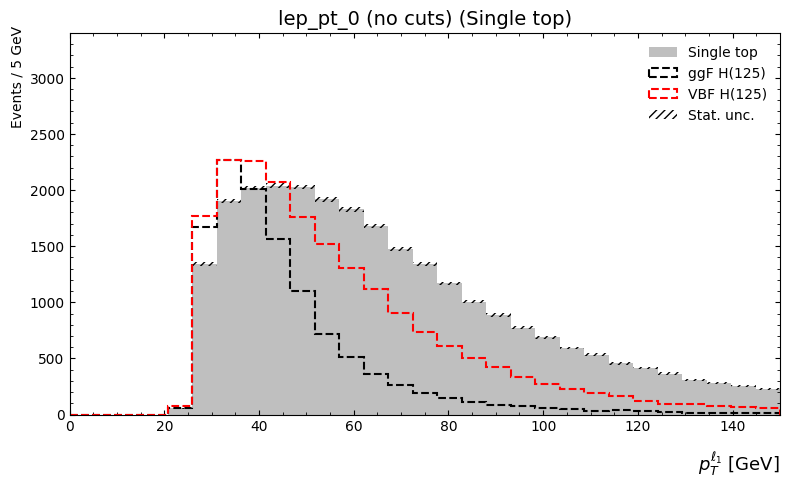

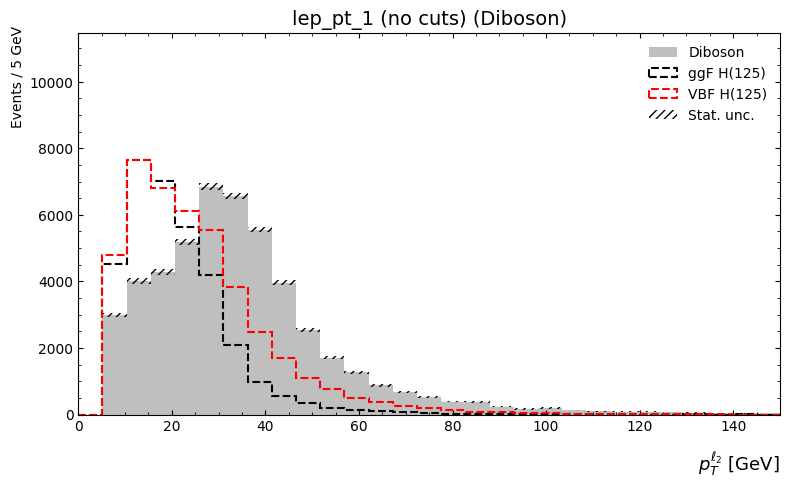

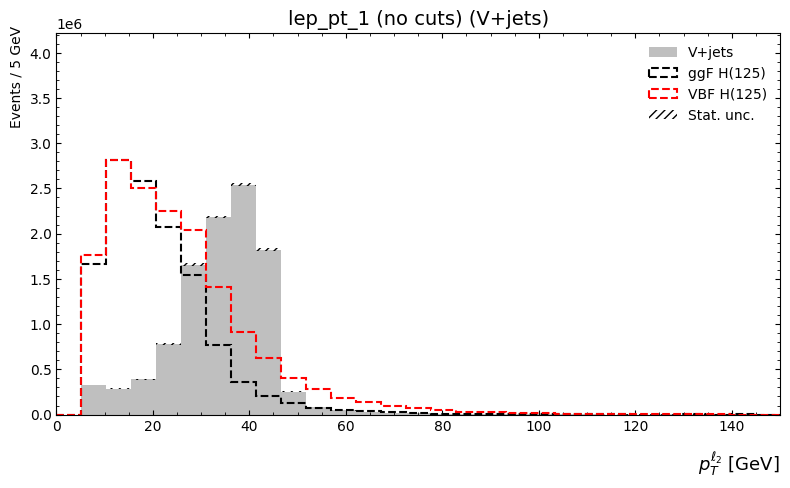

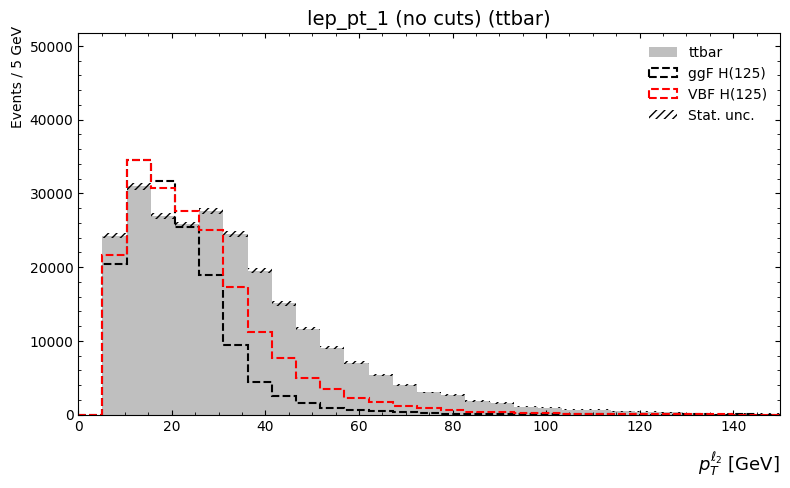

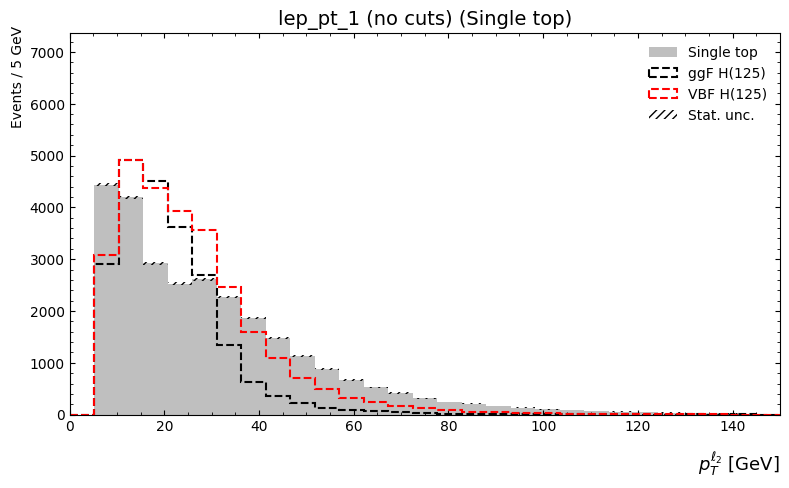

In [1]:
# import for plotting and files
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# only using 0ggF channel here, though the file names include "0ggF" because I named it poorly when running
channels = ["0ggF"]
selection_mode = "nocuts"  # label for selection mode used in file naming
json_dir = "background_json_by_selection_nocuts"  # input directory for background json files

# dictionary mapping signal display names to sample keys which are in the json files
signal_samples = {
    "ggF H(125)": "ggH125_WW2lep",
    "VBF H(125)": "VBFH125_WW2lep"
}

# colors to use for signal histograms
signal_colors = {
    "ggF H(125)": "black",
    "VBF H(125)": "red"
}
# list of variables to plot and settings to make the titles look nicer
variables_to_plot = {
    "delta_phi_ll_met": {"xlabel": r"$\Delta\phi_{\ell\ell,\mathrm{MET}}$", "bins": np.linspace(-4, 4, 30)},
    "delta_phi_ll": {"xlabel": r"$\Delta\phi_{\ell\ell}$", "bins": np.linspace(-4, 4, 30)},
    "mT": {"xlabel": r"$m_T$ [GeV]", "bins": np.linspace(0, 300, 30), "scale": 1e-3},  # convert MeV to GeV is what the scale means
    "mT_ell": {"xlabel": r"$m_T^{\ell}$ [GeV]", "bins": np.linspace(0, 300, 30)},
    "met_et": {"xlabel": r"$E_T^{\mathrm{miss}}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "osof_mass": {"xlabel": r"$m_{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "pT_ll": {"xlabel": r"$p_T^{\ell\ell}$ [GeV]", "bins": np.linspace(0, 200, 30), "scale": 1e-3},
    "lep_pt_0": {"xlabel": r"$p_T^{\ell_1}$ [GeV]", "bins": np.linspace(0, 150, 30), "scale": 1e-3},
    "lep_pt_1": {"xlabel": r"$p_T^{\ell_2}$ [GeV]", "bins": np.linspace(0, 150, 30), "scale": 1e-3},
}

# dictionary grouping background categories
group_map = {
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    "V+jets": ["Zjets", "Wjets"],
    "ttbar": ["top"],
    "Single top": ["top"]
}

# list of sample names to treat as ttbar or single top 
ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

# load background events for a given group/category
def load_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")  # path
    if not os.path.exists(filepath):  # skip if file is missing
        return []
    with open(filepath) as f:
        content = json.load(f)
    events = []
    for sample_name, evts in content["samples"].items():  # loop through samples in file
        if group_name == "ttbar" and sample_name not in ttbar_samples:  # filter ttbar samples
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:  # filter single top samples
            continue
        events.extend(evts)  # add events
    return events

# load signal events from the HWW signal file
def load_signal_events(channel, sample_name):
    filepath = os.path.join(json_dir, f"HWW_{channel}_{selection_mode}.json")
    if not os.path.exists(filepath):
        return []
    with open(filepath) as f:
        content = json.load(f)
    return content["samples"].get(sample_name, [])  # return only desired signal sample (not the others)

# loop over channels (only one here since its 0ggF but no cuts applied just bad naming)
for channel in channels:
    # loop over variables to plot
    for var, meta in variables_to_plot.items():
        bin_edges = meta["bins"]  # bin edges
        step_size = bin_edges[1] - bin_edges[0]  # bin width
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # bin centers
        xlabel = meta["xlabel"]  # x-axis label
        scale = meta.get("scale", 1.0)  # scaling factor (default = 1 but I scale the signal samples later for comparison)

        # loop over background groups (e.g., Diboson, V+jets)
        for group_name, cats in group_map.items():
            vals, wgts = [], []  # initialize arrays for variable values and weights
            for cat in cats:  # loop over categories in group
                events = load_events(channel, cat, group_name)
                for evt in events:
                    # deal with the two leptons
                    if var.startswith("lep_pt") and "lep_pt" in evt:
                        i = int(var[-1])  #  lepton index (0 or 1)
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True) # descending order
                        if len(leptons_sorted) > i: # get each lepton
                            vals.append(leptons_sorted[i] * scale)  # scaled lepton pt since I'm overlaying the signal
                            wgts.append(evt.get("weight", 1.0)) # weight
                    elif var in evt:  # for other variables that don't have two entries
                        vals.append(evt[var] * scale)
                        wgts.append(evt.get("weight", 1.0))

            # set up plot
            fig, ax = plt.subplots(figsize=(8, 5))
            # stacked histogram 
            counts, _, _ = ax.hist(vals, bins=bin_edges, weights=wgts, label=group_name,
                                   color="gray", histtype="stepfilled", alpha=0.5)

            # statistical uncertainty (sqrt of weighted counts squared)
            errors = np.sqrt(np.histogram(vals, bins=bin_edges, weights=np.square(wgts))[0])

            # error bars as shaded region with hatching
            ax.bar(bin_centres, 2 * errors, bottom=np.array(counts) - errors,
                   alpha=0.4, color='none', hatch="////", width=step_size,
                   label="Stat. unc.")
            ymax = max(counts + errors) * 1.1  # scale y-axis upper limit just so I can see without it being cut off
            # overlay signal samples
            for label, sample in signal_samples.items():  # loop through signal labels and corresponding sample keys
                events = load_signal_events(channel, sample)  # load signal events for this sample
                sig_vals, sig_wgts = [], []  # initialize arrays for variable values and event weights
            
                for evt in events:  # loop over each signal event
                    # deal with the two leptons in each event
                    if var.startswith("lep_pt") and "lep_pt" in evt:
                        i = int(var[-1])  # extract lepton index (0 or 1) from variable name
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)  # sort leptons by descending pt
                        if len(leptons_sorted) > i:  # make sure there are enough leptons
                            sig_vals.append(leptons_sorted[i] * scale)  # scale pt and append
                            sig_wgts.append(evt["weight"])  # store event weight
                    elif var in evt:  # for all other variables
                        sig_vals.append(evt[var] * scale)  # scale value and append
                        sig_wgts.append(evt["weight"])  # store event weight
            
                # only continue if we have signal values to plot, otherwise don't
                if sig_vals:
                    # compute histogram counts for signal (used to normalize)
                    sig_counts, _ = np.histogram(sig_vals, bins=bin_edges, weights=sig_wgts)
                    if np.max(sig_counts) > 0:  # check if signal has any nonzero entries
                        norm_factor = ymax / np.max(sig_counts)  # scale signal so max matches plot y-axis
                        sig_wgts = [w * norm_factor for w in sig_wgts]  # apply scaling to all weights
            
                        # plot signal as dashed outline histogram
                        ax.hist(sig_vals, bins=bin_edges, weights=sig_wgts,
                                histtype="step", linewidth=1.5, linestyle="--",
                                label=label, color=signal_colors[label])  # use assigned label and color


            # formatting plot so it looks nice
            ax.set_xlim(bin_edges[0], bin_edges[-1])
            ax.set_ylim(bottom=0, top=ymax*1.5)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.tick_params(which='both', direction='in', top=True, right=True)
            ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)
            ylabel_unit = "GeV" if "GeV" in xlabel else "rad"  # set y-axis unit
            step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'  # bin width label
            ax.set_ylabel(f'Events / {step_label} {ylabel_unit}', y=1.02, ha='right')  # y-axis label
            ax.legend(frameon=False)  # show legend without box
            ax.set_title(f"{var} (no cuts) ({group_name})", fontsize=14)  # plot title
            plt.tight_layout()
            plt.subplots_adjust(top=0.92)
            plt.show()  # display plot


# njet plots

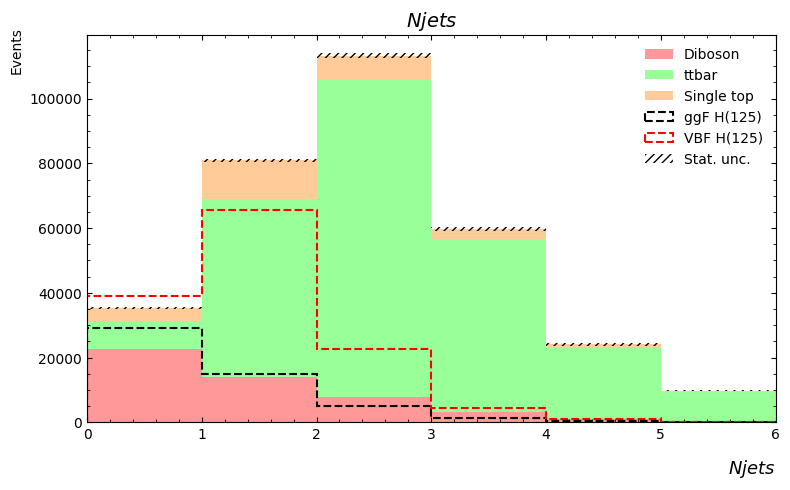

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator 


channels = ["0ggF"]  # not really this SR just bad naming from me
selection_mode = "nocuts"  # no cuts applied
json_dir = "background_json_by_selection_nocuts"  # directory where background jsons are stored

# dictionary of signal samples to overlay
signal_samples = {
    "ggF H(125)": "ggH125_WW2lep",
    "VBF H(125)": "VBFH125_WW2lep"
}
# color for each signal sample
signal_colors = {
    "ggF H(125)": "black",
    "VBF H(125)": "red"
}
# scale factor for each signal (to make it visible on plot)
signal_scales = {
    "ggF H(125)": 120,
    "VBF H(125)": 2000
}
# plotting Njets
variables_to_plot = {
    "Njets": {"xlabel": r"$Njets$", "bins": np.linspace(0, 6, 7)},
}

# mapping of background groups to categories in the jsons
group_map = {
    "Diboson": ["diboson_leptonic", "diboson_semileptonic"],
    # "V+jets": ["Zjets", "Wjets"],  # skipped for visibility reasons (dominates)
    "ttbar": ["top"],
    "Single top": ["top"]
}
# sample names used to identify ttbar and single top events
ttbar_samples = ["ttbar_lep"]
single_top_samples = [
    'single_top_tchan', 'single_antitop_tchan', 'single_top_wtchan',
    'single_antitop_wtchan', 'single_top_schan', 'single_antitop_schan'
]

# color for each background group
group_colors = {
    "Diboson": "#ff9999",
    # "V+jets": "#66b3ff",  # skipped
    "ttbar": "#99ff99",
    "Single top": "#ffcc99"
}

# function to load mc events for a given group and category
def load_events(channel, cat, group_name):
    filepath = os.path.join(json_dir, f"{cat}_{channel}_{selection_mode}.json")  #path to json file
    if not os.path.exists(filepath):  # skip if file not found
        return []
    with open(filepath) as f:
        content = json.load(f)  # load the json content
    events = []
    for sample_name, evts in content["samples"].items():
        # apply filtering for ttbar and single top samples
        if group_name == "ttbar" and sample_name not in ttbar_samples:
            continue
        if group_name == "Single top" and sample_name not in single_top_samples:
            continue
        events.extend(evts)  # add valid events to the list
    return events

# function to load signal events from the HWW signal json file
def load_signal_events(channel, sample_name):
    filepath = os.path.join(json_dir, f"HWW_{channel}_{selection_mode}.json")  # path to signal json
    if not os.path.exists(filepath):  # skip if file not found
        return []
    with open(filepath) as f:
        content = json.load(f)  # load the json
    return content["samples"].get(sample_name, [])  # return events for the signal sample

# main loop
for channel in channels:
    for var, meta in variables_to_plot.items():  # loop through each variable to plot
        bin_edges = meta["bins"]  # get bin edges for histogram
        step_size = bin_edges[1] - bin_edges[0]  # compute bin width
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # compute bin centers for plotting
        xlabel = meta["xlabel"]  # get x-axis label
        scale = meta.get("scale", 1.0)  # the scale factor is just 1 here, but for things like pT i scale to GeV

        fig, ax = plt.subplots(figsize=(8, 5)) 

        # initialize lists for stacked mc histograms
        stack_vals = []
        stack_wgts = []
        stack_colors = []
        stack_labels = []
        # store all mc values and weights for total error band
        all_mc_vals = []
        all_mc_weights = []

        # loop through each background group 
        for group_name, cats in group_map.items():
            group_vals, group_wgts = [], []
            for cat in cats:
                events = load_events(channel, cat, group_name)  # load events for this category
                for evt in events:
                    if var.startswith("lep_pt") and "lep_pt" in evt:  # deal with the two leptons
                        i = int(var[-1])
                        leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                        if len(leptons_sorted) > i:
                            group_vals.append(leptons_sorted[i] * scale)
                            group_wgts.append(evt.get("weight", 1.0))  # weight
                    elif var in evt:  # for variables that don't have multiple values per event
                        group_vals.append(evt[var] * scale)
                        group_wgts.append(evt.get("weight", 1.0))
            if group_vals:
                stack_vals.append(group_vals)
                stack_wgts.append(group_wgts)
                stack_colors.append(group_colors[group_name])
                stack_labels.append(group_name)
                all_mc_vals.append(group_vals)
                all_mc_weights.append(group_wgts)
        #stacked histogram of all background mc groups
        ax.hist(all_mc_vals, bins=bin_edges, weights=all_mc_weights,
                stacked=True, color=stack_colors, label=stack_labels)
        # compute statistical uncertainty for total mc
        flat_vals = np.hstack(all_mc_vals)
        flat_weights = np.hstack(all_mc_weights)
        mc_totals, _ = np.histogram(flat_vals, bins=bin_edges, weights=flat_weights)
        mc_errors = np.sqrt(np.histogram(flat_vals, bins=bin_edges, weights=flat_weights**2)[0])
        # mc error
        ax.bar(bin_centres, 2 * mc_errors, bottom=mc_totals - mc_errors,
               alpha=0.5, color='none', hatch="////", width=step_size,
               label="Stat. unc.")
        # overlay signal histograms
        for label, sample in signal_samples.items():
            events = load_signal_events(channel, sample)  # load signal events
            sig_vals, sig_wgts = [], []
            for evt in events:
                if var.startswith("lep_pt") and "lep_pt" in evt:  # deal with the leptons
                    i = int(var[-1])
                    leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                    if len(leptons_sorted) > i:
                        sig_vals.append(leptons_sorted[i] * scale)
                        sig_wgts.append(evt["weight"] * signal_scales[label])  # apply signal scale to make it visible
                elif var in evt:  # other variables
                    sig_vals.append(evt[var] * scale)
                    sig_wgts.append(evt["weight"] * signal_scales[label])
            if sig_vals:
                ax.hist(sig_vals, bins=bin_edges, weights=sig_wgts,
                        histtype="step", linewidth=1.5, linestyle="--",
                        label=label, color=signal_colors[label])  # draw as outlined line

        # plot formatting
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # set x-axis range
        ax.set_ylim(bottom=0)  # y-axis minimum
        # add minor ticks
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', direction='in', top=True, right=True)  # ticks inward
        # label the axes
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)
        ylabel_unit = "GeV" if "GeV" in xlabel else "rad"
        step_label = f'{step_size:.0f}' if step_size >= 1 else f'{step_size:.2f}'
        ax.set_ylabel(f'Events', y=1.02, ha='right')  # y-axis doesn't show bin width here
        ax.legend(frameon=False)  # show legend without frame
        ax.set_title(f"{xlabel}", fontsize=14)  # set plot title
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # adjust spacing
        plt.show() 

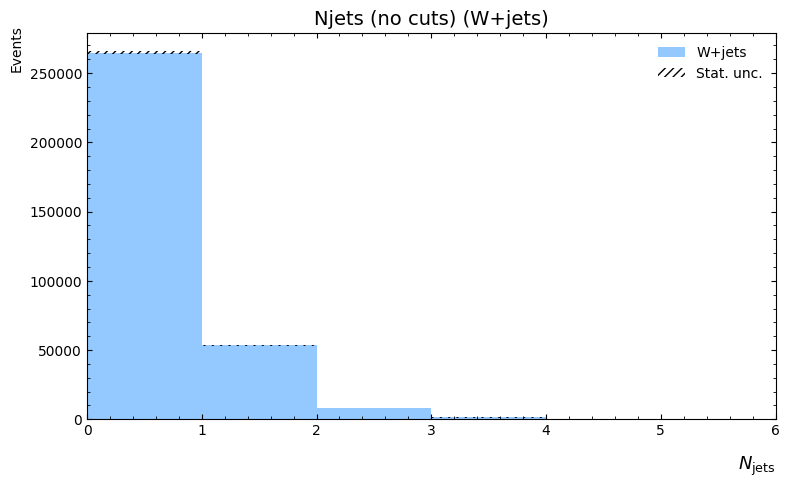

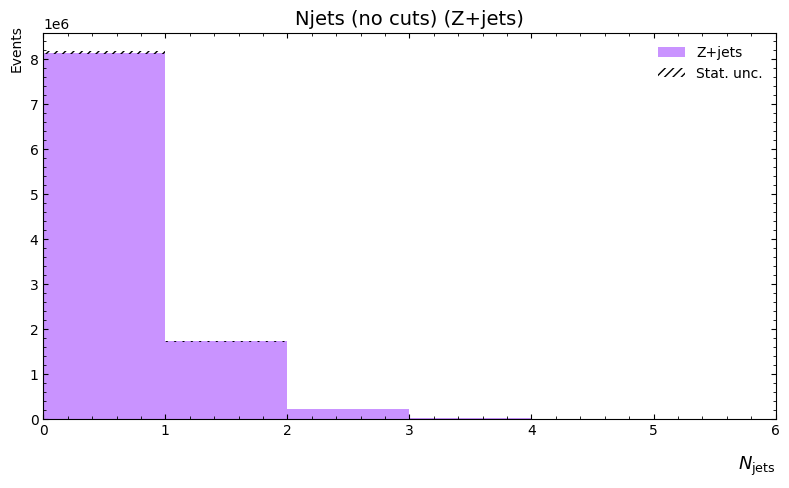

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator  


channel = "0ggF"  # this is really no selection just bad file naming from me
selection_mode = "nocuts"  # no selection applied
json_dir = "background_json_by_selection_nocuts"  # folder containing json files

# plot Njets
variables_to_plot = {
    "Njets": {"xlabel": r"$N_{\text{jets}}$", "bins": np.linspace(0, 6, 7)}, 
}

# samples for W+jets
wjets_samples = [
    'Wplusenu', 'Wminusenu',
    'Wplusmunu', 'Wminusmunu',
    'Wplustaunu', 'Wminustaunu'
]
# list of sample for Z+jets
zjets_samples = [
    'Zee', 'Zmumu', 'Ztautau'
]
# groups and colours
group_configs = {
    "W+jets": {
        "samples": wjets_samples,
        "color": "#66b3ff"
    },
    "Z+jets": {
        "samples": zjets_samples,
        "color": "#b266ff"
    }
}

# load Wjets and Zjets events from jsons files based on selected samples
def load_events(channel, group_samples):
    all_events = []  # container for all loaded events

    # load Wjets json and filter 
    filepath = os.path.join(json_dir, f"Wjets_{channel}_{selection_mode}.json")
    if os.path.exists(filepath):
        with open(filepath) as f:
            content = json.load(f)
        for name, evts in content["samples"].items():
            if name in group_samples:
                all_events.extend(evts)

    # load Zjets json and filter
    filepath = os.path.join(json_dir, f"Zjets_{channel}_{selection_mode}.json")
    if os.path.exists(filepath):
        with open(filepath) as f:
            content = json.load(f)
        for name, evts in content["samples"].items():
            if name in group_samples:
                all_events.extend(evts)
    return all_events  # return combined list of events
# loop over both
for group_name, cfg in group_configs.items():  # loop over each group (W+jets, Z+jets)
    for var, meta in variables_to_plot.items():  # loop over each variable to plot
        bin_edges = meta["bins"]  # get histogram bin edges
        step_size = bin_edges[1] - bin_edges[0]  # compute bin width
        bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # compute bin centers for error bars
        xlabel = meta["xlabel"]  # get x-axis label
        scale = meta.get("scale", 1.0)  # no change to the scale, but when I plot things like pT I scale to GeV

        vals, wgts = [], []  # containers for variable values and weights
        events = load_events(channel, cfg["samples"])  # load all matching events for this group
        for evt in events:
            if var.startswith("lep_pt") and "lep_pt" in evt:  # if variable is lepton pT (not used here, just copying from other code)
                i = int(var[-1])
                leptons_sorted = sorted(evt["lep_pt"], reverse=True)
                if len(leptons_sorted) > i:
                    vals.append(leptons_sorted[i] * scale)
                    wgts.append(evt.get("weight", 1.0))  # weight
            elif var in evt:  # for variables not containing multiple entries per event like the lepton stuff
                vals.append(evt[var] * scale)
                wgts.append(evt.get("weight", 1.0))

        fig, ax = plt.subplots(figsize=(8, 5))

        # filled histogram of variable values with weights
        counts, _, _ = ax.hist(vals, bins=bin_edges, weights=wgts,
                               color=cfg["color"], label=group_name,
                               histtype="stepfilled", alpha=0.7)
        # errors
        errors = np.sqrt(np.histogram(vals, bins=bin_edges, weights=np.square(wgts))[0])
        # error band
        ax.bar(bin_centres, 2 * errors, bottom=np.array(counts) - errors,
               alpha=0.5, color='none', hatch="////", width=step_size,
               label="Stat. unc.")
        # set x-axis and y-axis limits
        ax.set_xlim(bin_edges[0], bin_edges[-1])
        ax.set_ylim(bottom=0)
        # add minor ticks on both axes
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        # set tick direction and placement
        ax.tick_params(which='both', direction='in', top=True, right=True)
        # label the x-axis and y-axis
        ax.set_xlabel(xlabel, fontsize=13, x=1, ha='right', labelpad=12)
        ax.set_ylabel("Events", y=1.02, ha='right')
        ax.legend(frameon=False)
        ax.set_title(f"{var} (no cuts) ({group_name})", fontsize=14)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()